# Model18: NE(Named Entity) take 2

In [1]:
from utils import load_buzz, select, write_result
from features import featurize, get_pos
from containers import Questions, Users, Categories
from nlp import extract_entities

## GMM

### Classifying questions
features: avg_pos, accuracy rate

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture


def plot_gmm(X, models, n_components, covariance_type='diag', n_iter=100,
            figsize=(10, 20), suptitle=None, xlabel=None, ylabel=None):
    color_iter = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray', 'pink', 'lime']
    plt.figure(figsize=figsize)
    plt.suptitle(suptitle, fontsize=20)

    for i, model in enumerate(models):
        mm = getattr(mixture, model)(n_components=n_components,
                                     covariance_type=covariance_type,
                                     n_iter=n_iter)
        mm.fit(X_pos_qid)
        Y = mm.predict(X_pos_qid)

        plt.subplot(len(models), 1, 1 + i)
        for i, color in enumerate(color_iter):
            plt.scatter(X_pos_qid[Y == i, 0], X_pos_qid[Y == i, 1], .7, color=color)
        plt.title(model, fontsize=15)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid()

    plt.show()

In [3]:
users = Users(load_buzz())
questions = Questions(load_buzz())
X_pos_uid = users.select(['ave_pos_uid', 'acc_ratio_uid'])
X_pos_qid = questions.select(['ave_pos_qid', 'acc_ratio_qid'])

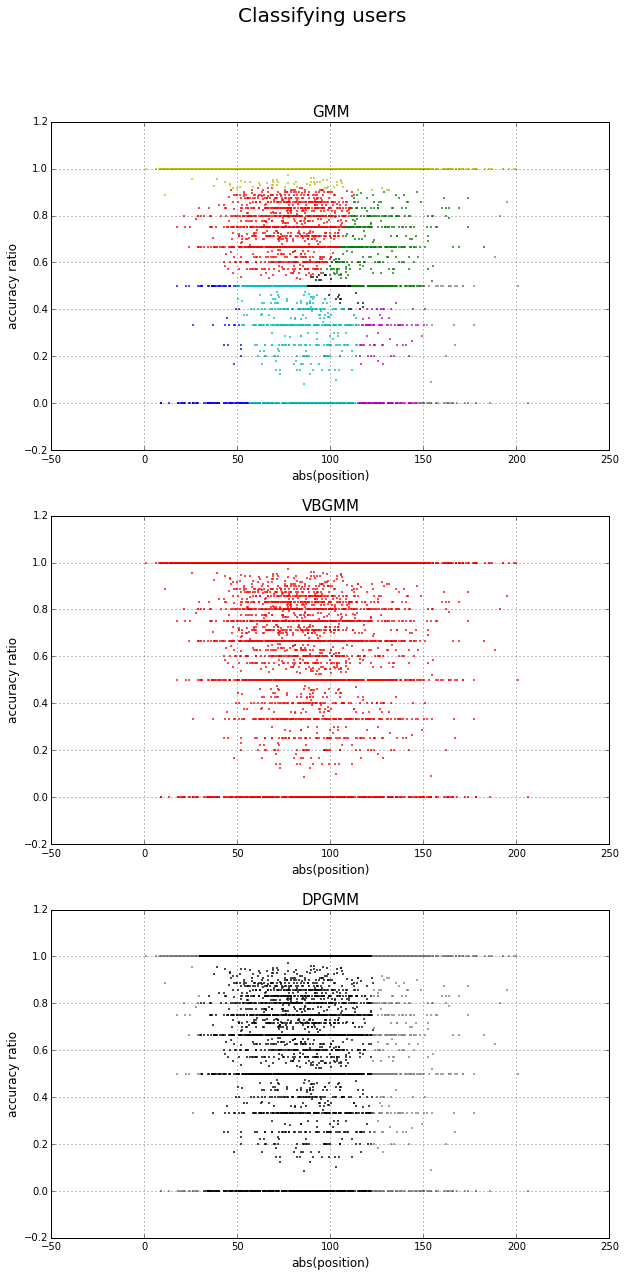

In [4]:
plot_gmm(X_pos_uid,
         models=['GMM', 'VBGMM', 'DPGMM'],
         n_components=8,
         covariance_type='diag',
         figsize=(10, 20),
         suptitle='Classifying users',
         xlabel='abs(position)',
         ylabel='accuracy ratio')

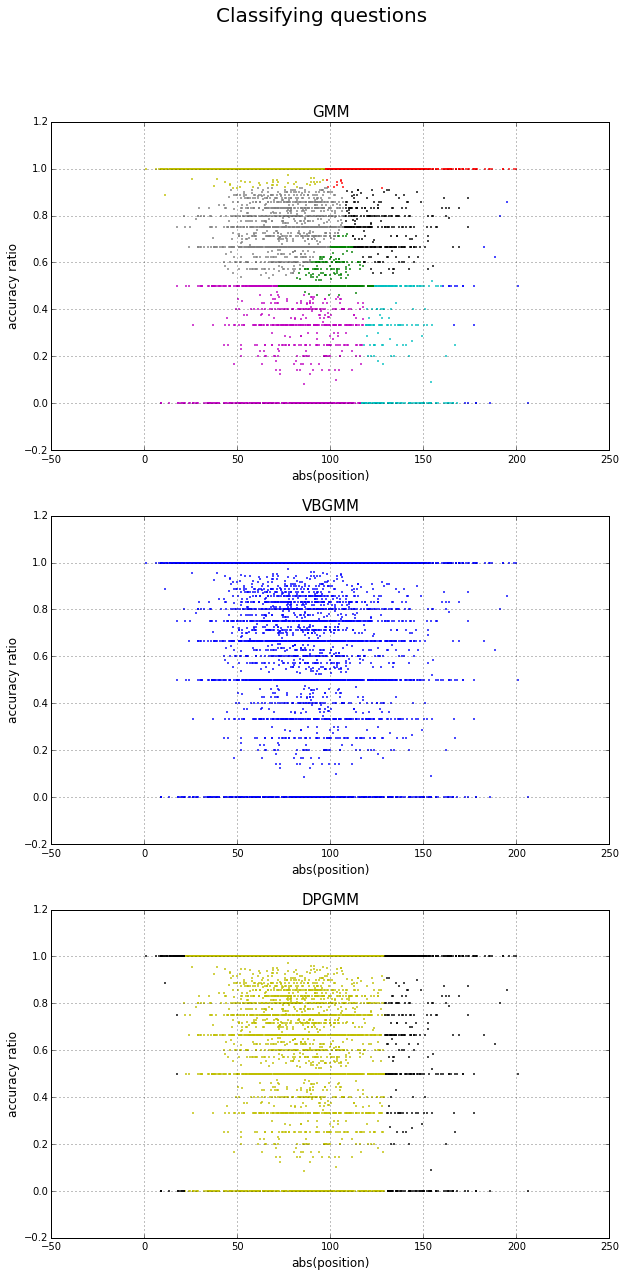

In [5]:
plot_gmm(X_pos_qid,
         models=['GMM', 'VBGMM', 'DPGMM'],
         n_components=8,
         covariance_type='diag',
         figsize=(10, 20),
         suptitle='Classifying questions',
         xlabel='abs(position)',
         ylabel='accuracy ratio')

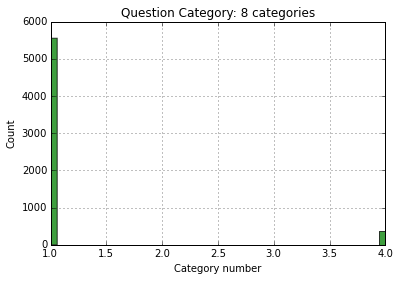

In [6]:
# Question category
n_components = 8
gmm = mixture.DPGMM(n_components=n_components, covariance_type='diag', n_iter=10**10)
gmm.fit(X_pos_qid)
pred_cat_qid = gmm.predict(X_pos_qid)

plt.hist(pred_cat_qid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("Question Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

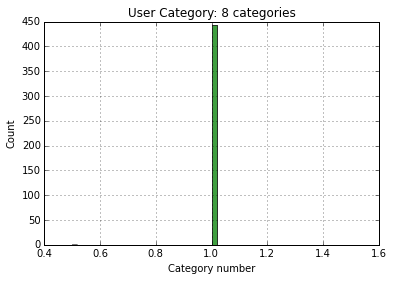

In [7]:
# User category
n_components = 8
gmm = mixture.DPGMM(n_components=n_components, covariance_type='diag', n_iter=10**10)
gmm.fit(X_pos_uid)
pred_cat_uid = gmm.predict(X_pos_uid)

plt.hist(pred_cat_uid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("User Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

In [8]:
from collections import Counter


users.sub_append('cat_uid', [str(x) for x in pred_cat_uid])
questions.sub_append('cat_qid', [str(x) for x in pred_cat_qid])

# to get most frequent cat for some test data which do not have ids in train set
most_pred_cat_uid = Counter(pred_cat_uid).most_common(1)[0][0]
most_pred_cat_qid = Counter(pred_cat_qid).most_common(1)[0][0]

print(most_pred_cat_uid)
print(most_pred_cat_qid)

1
1


In [9]:
print(users[1])
print(questions[1])

{'ave_pos_uid': 96.724899598393577, 'acc_ratio_uid': 0.6465863453815262, 'cat_uid': '1'}
{'cat_qid': '1', 'group': 'test', 'acc_ratio_qid': 0.875, 'category': 'Fine Arts', 'answer': 'thomas cole', 'ave_pos_qid': 70.5, 'pos_token': {0: '', 1: 'painters', 2: 'indulgence', 4: 'visual', 5: 'fantasy', 68: 'this_painter', 7: 'appreciation', 64: 'mountains', 9: 'different', 10: 'historic', 11: 'architectural', 12: 'styles', 66: 'name', 77: 'series', 15: 'seen', 18: '1840', 19: 'architects', 20: 'dream', 23: 'series', 25: 'paintings', 28: 'last', 31: 'mohicans', 33: 'made', 35: 'three', 36: 'year', 37: 'trip', 65: 'ftp', 39: 'europe', 41: '1829', 71: 'oxbow', 45: 'better', 46: 'known', 76: 'life', 49: 'trip', 50: 'four', 51: 'years', 52: 'earlier', 56: 'journeyed', 59: 'hudson', 60: 'river', 74: 'voyage', 63: 'catskill'}, 'question': "This painter's indulgence of visual fantasy, and appreciation of different historic architectural styles can be seen in his 1840 Architect's Dream. After a serie

## B. Modeling

In [10]:
regression_keys = ['category', 'q_length', 'qid', 'uid', 'answer', 'avg_pos_uid', 'avg_pos_qid']
X_train, y_train = featurize(load_buzz(), group='train', sign_val=None, extra=['sign_val', 'avg_pos'])
X_train = select(X_train, regression_keys)

In [11]:
categories = Categories(load_buzz())

In [12]:
for item in X_train:
    for key in categories[item['category']].keys():
        item[key] = categories[item['category']][key]

In [13]:
X_train[1]

{'acc_ratio_cat': 0.7560975609756098,
 'answer': 'thomas cole',
 'ave_pos_cat': 43.640185830429736,
 'avg_pos_qid': 51.0,
 'avg_pos_uid': 30.973895582329316,
 'category': 'fine arts',
 'q_length': 78,
 'qid': 1,
 'uid': 1}

In [14]:
extract_entities(questions[1]['question'], all=False, verbose=False)

[['CD', '1840', 20],
 ['PERSON', 'Architect', 21],
 ['CD', 'three', 40],
 ['GPE', 'Europe', 44],
 ['CD', '1829', 46],
 ['CD', 'four', 56],
 ['ORGANIZATION', 'Hudson', 65],
 ['ORGANIZATION', 'Catskill', 69],
 ['ORGANIZATION', 'FTP', 72],
 ['ORGANIZATION', 'Oxbow', 79],
 ['ORGANIZATION', 'Voyage', 82],
 ['GPE', 'Life', 84]]

In [15]:
import pickle


with open('ne_count02.pkl', 'rb') as f:
    nes = pickle.load(f)

In [16]:
nes[1]

[['CD', '1840', 20],
 ['PERSON', 'Architect', 21],
 ['CD', 'three', 40],
 ['GPE', 'Europe', 44],
 ['CD', '1829', 46],
 ['CD', 'four', 56],
 ['ORGANIZATION', 'Hudson', 65],
 ['ORGANIZATION', 'Catskill', 69],
 ['ORGANIZATION', 'FTP', 72],
 ['ORGANIZATION', 'Oxbow', 79],
 ['ORGANIZATION', 'Voyage', 82],
 ['GPE', 'Life', 84]]

In [17]:
pos = list(zip(*nes[1]))[-1]
print(pos)

(20, 21, 40, 44, 46, 56, 65, 69, 72, 79, 82, 84)


In [18]:
import numpy as np


mean = sum(pos) / len(pos)
nor_mean = (sum(pos)/len(pos)) / len(questions[1]['question'].split())
median = np.median(pos)
mod = max(set(pos), key=pos.count)
print(mean, nor_mean, median, mod)

56.5 0.7243589743589743 60.5 65


In [19]:
import numpy as np

"""
This is sort of temporary function for adding some features.
"""
def transform(X):
    for index, item in enumerate(X):
        uid = int(item['uid'])
        qid = int(item['qid'])

        # uid
        if int(uid) in users:
            item['acc_ratio_uid'] = users[uid]['acc_ratio_uid']
            item['cat_uid'] = users[uid]['cat_uid']
        else:
            acc = users.select(['acc_ratio_uid'])
            item['acc_ratio_uid'] = sum(acc) / float(len(acc))
            item['cat_uid'] = most_pred_cat_uid

        # qid
        if int(qid) in questions:
            item['acc_ratio_qid'] = questions[qid]['acc_ratio_qid']
            item['cat_qid'] = questions[qid]['cat_qid']
            # For Named Entity
            try:
                ne = list(zip(*nes[qid]))[-1]
                item['ne_count'] = len(ne)
                mean = sum(ne) / float(len(ne))
                nor_mean = (sum(ne)/len(ne)) / len(questions[qid]['question'].split())
                median = np.median(ne)
                mod = max(set(ne), key=ne.count)
            except:
                # qid 8216 does could not parsed well by ne
                # so it does not have ne
                print("WARN: qid", qid, "doesn't have NE so it's mean, nor_mean, median, mod will be 0.")
                mean = 0
                nor_mean = 0
                median = 0
                mod = 0
            item['ne_mean'] = mean
            item['ne_nor_mean'] = nor_mean
            item['ne_median'] = median
            item['ne_mod'] = mod
        else:
            acc = questions.select(['acc_ratio_qid'])
            item['acc_ratio_qid'] = sum(acc) / float(len(acc))
            item['cat_qid'] = most_pred_cat_qid

        item['uid'] = str(uid)
        item['qid'] = str(qid)

In [20]:
transform(X_train)
X_train[1]

WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, m

{'acc_ratio_cat': 0.7560975609756098,
 'acc_ratio_qid': 0.875,
 'acc_ratio_uid': 0.6465863453815262,
 'answer': 'thomas cole',
 'ave_pos_cat': 43.640185830429736,
 'avg_pos_qid': 51.0,
 'avg_pos_uid': 30.973895582329316,
 'cat_qid': '1',
 'cat_uid': '1',
 'category': 'fine arts',
 'ne_count': 12,
 'ne_mean': 56.5,
 'ne_median': 60.5,
 'ne_mod': 65,
 'ne_nor_mean': 0.7243589743589743,
 'q_length': 78,
 'qid': '1',
 'uid': '1'}

In [21]:
from sklearn.feature_extraction import DictVectorizer


vec = DictVectorizer()
X_train_dict_vec = vec.fit_transform(X_train)

In [22]:
import multiprocessing
from sklearn import linear_model
from sklearn.cross_validation import train_test_split, cross_val_score
import math
from numpy import abs, sqrt


regressor_names = """
ElasticNetCV
"""
for l1 in [0.5, 0.65, 0.7, 0.75]:
    print ("=== ElasticNetCV RMSE", "with", l1)
    for regressor in regressor_names.split():
        scores = cross_val_score(getattr(linear_model, regressor)(n_jobs=3, normalize=True, l1_ratio = l1),
                                 X_train_dict_vec, y_train,
                                 cv=2,
                                 scoring='mean_squared_error'
                                )
        print (regressor, sqrt(abs(scores)).mean())

=== ElasticNetCV RMSE with 0.5
ElasticNetCV 78.8930627416
=== ElasticNetCV RMSE with 0.65
ElasticNetCV 76.8159600574
=== ElasticNetCV RMSE with 0.7
ElasticNetCV 76.1299738794
=== ElasticNetCV RMSE with 0.75
ElasticNetCV 75.452306948


### Training and testing model

In [23]:
regression_keys = ['category', 'q_length', 'qid', 'uid', 'answer', 'avg_pos_uid', 'avg_pos_qid']
X_train, y_train = featurize(load_buzz(), group='train', sign_val=None, extra=['avg_pos'])
X_train = select(X_train, regression_keys)
X_test = featurize(load_buzz(), group='test', sign_val=None, extra=['avg_pos'])
X_test = select(X_test, regression_keys)

transform(X_train)
transform(X_test)

for item in X_train:
    for key in categories[item['category']].keys():
        item[key] = categories[item['category']][key]

for item in X_test:
    for key in categories[item['category']].keys():
        item[key] = categories[item['category']][key]

WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, mod will be 0.
WARN: qid 8216 doesn't have NE so it's mean, nor_mean, median, m

In [24]:
X_train[1]

{'acc_ratio_cat': 0.7560975609756098,
 'acc_ratio_qid': 0.875,
 'acc_ratio_uid': 0.6465863453815262,
 'answer': 'thomas cole',
 'ave_pos_cat': 43.640185830429736,
 'avg_pos_qid': 51.0,
 'avg_pos_uid': 30.973895582329316,
 'cat_qid': '1',
 'cat_uid': '1',
 'category': 'fine arts',
 'ne_count': 12,
 'ne_mean': 56.5,
 'ne_median': 60.5,
 'ne_mod': 65,
 'ne_nor_mean': 0.7243589743589743,
 'q_length': 78,
 'qid': '1',
 'uid': '1'}

In [25]:
X_test[1]

{'acc_ratio_cat': 0.65625,
 'acc_ratio_qid': 0.6428571428571429,
 'acc_ratio_uid': 0.6712328767123288,
 'answer': 'david hilbert',
 'ave_pos_cat': 18.712499999999999,
 'avg_pos_qid': 15.571428571428571,
 'avg_pos_uid': 36.31506849315068,
 'cat_qid': '1',
 'cat_uid': '1',
 'category': 'mathematics',
 'ne_count': 9,
 'ne_mean': 85.11111111111111,
 'ne_median': 97.0,
 'ne_mod': 97,
 'ne_nor_mean': 0.8105820105820106,
 'q_length': 105,
 'qid': '9967',
 'uid': '131'}

In [26]:
vec = DictVectorizer()
vec.fit(X_train + X_test)
X_train = vec.transform(X_train)
X_test = vec.transform(X_test)

In [ ]:
for l1_ratio in [0.66, 0.68, 0.7, 0.72, 0.74, 0.76]:
    print('=== l1_ratio:', l1_ratio)
    regressor = linear_model.ElasticNetCV(n_jobs=3, normalize=True, l1_ratio=l1_ratio)
    regressor.fit(X_train, y_train)
    print(regressor.coef_)
    print(regressor.alpha_)
    predictions = regressor.predict(X_test)
    write_result(load_buzz()['test'], predictions, file_name=str(l1_ratio)+'guess.csv')

=== l1_ratio: 0.66
[ 14.91074767  22.69045598  20.40401633 ...,   6.66222052   1.16271066
   4.36179624]